In [1]:
%matplotlib inline
from fastai import *
from fastai.vision import *

### Data

untar_data downloads by default to ~/.fastai/data, but this can be changed by passing the dest parameter

In [2]:
path = untar_data(URLs.MNIST)

In [3]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/training'),
 PosixPath('/root/.fastai/data/mnist_png/testing')]

'L' mode in Pillow means greyscale

In [4]:
# Pillow's convert mode L
# ImageList replaces ImageItemList
il = ImageList.from_folder(path, convert_mode='L')

In [5]:
il.items[0]

PosixPath('/root/.fastai/data/mnist_png/training/9/46065.png')

In [6]:
# Binary color map (matplotlib)
defaults.cmap='binary'

In [7]:
il # PyTorch puts channel first

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png

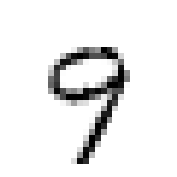

In [8]:
il[0].show()

In [9]:
# use .no_split to get an empty validation set
# testing folder is a validation set bc it has labels
sd = il.split_by_folder(train='training', valid='testing')

In [10]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Test: None

In [11]:
# a folder for each class
(path/'training').ls()

[PosixPath('/root/.fastai/data/mnist_png/training/9'),
 PosixPath('/root/.fastai/data/mnist_png/training/0'),
 PosixPath('/root/.fastai/data/mnist_png/training/1'),
 PosixPath('/root/.fastai/data/mnist_png/training/2'),
 PosixPath('/root/.fastai/data/mnist_png/training/6'),
 PosixPath('/root/.fastai/data/mnist_png/training/7'),
 PosixPath('/root/.fastai/data/mnist_png/training/3'),
 PosixPath('/root/.fastai/data/mnist_png/training/5'),
 PosixPath('/root/.fastai/data/mnist_png/training/4'),
 PosixPath('/root/.fastai/data/mnist_png/training/8')]

In [12]:
# label the data
ll = sd.label_from_folder()

In [13]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
9,9,9,9,9
Path: /root/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
9,9,9,9,9
Path: /root/.fastai/data/mnist_png;

Test: None

In [14]:
x, y = ll.train[0]

9 torch.Size([1, 28, 28])


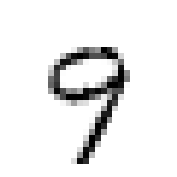

In [15]:
x.show()
print(y, x.shape)

In [16]:
# the transformations are not too crazy to preserve 
# the meaning of the images, here we just add some random padding
# the empty array refers to the validation set transforms (no transforms)
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [17]:
ll = ll.transform(tfms)

In [18]:
# batch size
bs = 128

In [19]:
data = ll.databunch(bs=bs).normalize()

In [20]:
x, y = data.train_ds[0]

9


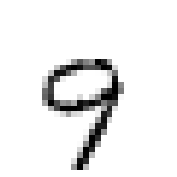

In [21]:
x.show()
print(y)

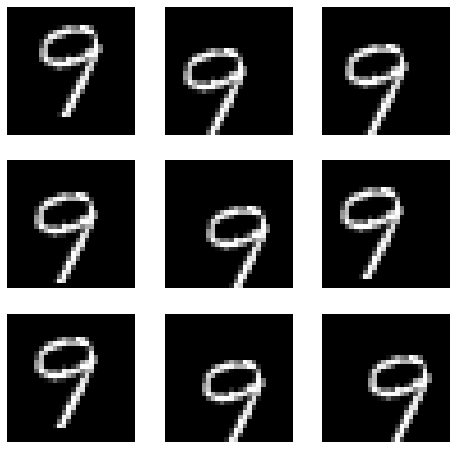

In [22]:
# grabs an image from dataset
# this loads it from disk and transforms it on the fly
def _plot(i, j, ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8, 8))

In [23]:
xb, yb = data.one_batch()
xb.shape, yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

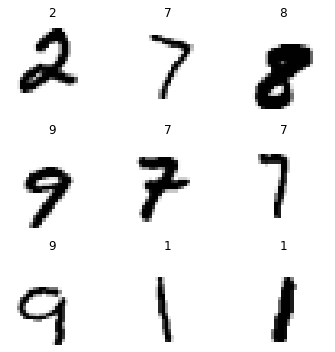

In [24]:
data.show_batch(rows=3, figsize=(5, 5))

### Basic CNN with batchnorm

In [25]:
# the stride is 2 so it halves the grid size
def conv(ni, nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [26]:
model = nn.Sequential(
    conv(1, 8), # 8x14x14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 16x7x7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 32x4x4
    nn.ReLU(),
    conv(32, 16), # 16x2x2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), #10x1x1
    nn.BatchNorm2d(10),
    Flatten() # remove (1, 1) grid
)

In [27]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [28]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [29]:
xb = xb.cuda()

In [30]:
model(xb).shape

torch.Size([128, 10])

In [31]:
learn.lr_find(end_lr=100)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


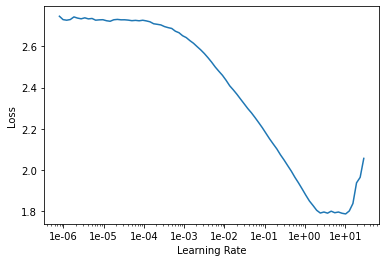

In [32]:
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.218210,0.200601,0.933300,00:27
1,0.126152,0.086150,0.973600,00:27
2,0.071205,0.038698,0.988000,00:28


### Refactor

In [34]:
def conv2(ni, nf): return conv_layer(ni, nf, stride=2) #conv_layer has conv2d batchnorm relu

In [35]:
model = nn.Sequential(
    conv2(1, 8), # 8x14x14
    conv2(8, 16), # 16x7x7
    conv2(16, 32), # 32x24x4
    conv2(32, 16), # 16x2x2
    conv2(16, 10), # 10x1x1
    Flatten() # remove(1, 1)
)

In [36]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [37]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.243850,0.197794,0.935300,00:28
1,0.187784,0.157552,0.951900,00:28
2,0.168807,0.143615,0.954500,00:28
3,0.125362,0.135118,0.958800,00:28
4,0.126477,0.103676,0.966600,00:28
5,0.098707,0.075503,0.975500,00:29
6,0.081937,0.052360,0.984800,00:28
7,0.058489,0.032587,0.990000,00:28
8,0.047146,0.030549,0.990600,00:28
9,0.044615,0.027600,0.991800,00:28


### Resnet-ish

In [38]:
class ResBlock(nn.Module):
  def __init__(self, nf):
    super().__init__
    self.conv1 = conv_layer(nf, nf)
    self.conv2 = conv_layer(nf, nf)

    def forward(self, x): return x + self.conv2(self.conv1(x))

In [39]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, bottle:bool=False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [40]:
# This should be able to compute more, but it shouldn't be harder to train than a model without the res_blocks
# Ref: Visualizing the Loss Landscape of Neural Nets*
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [41]:
def conv_and_res(ni, nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [42]:
# refactor
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [43]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


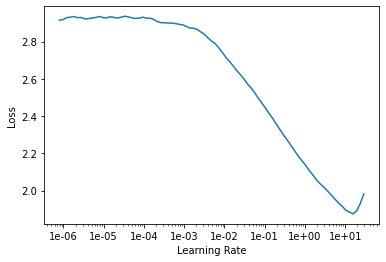

In [44]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [45]:
learn.fit_one_cycle(12, max_lr=0.05) 

epoch,train_loss,valid_loss,accuracy,time
0,0.209012,0.236355,0.931400,00:31
1,0.138702,0.261854,0.928300,00:31
2,0.106908,0.097488,0.970700,00:31
3,0.081230,0.177991,0.947800,00:31
4,0.073031,0.045854,0.986400,00:31
5,0.060952,0.057165,0.982600,00:31
6,0.058918,0.084689,0.971900,00:31
7,0.036223,0.044939,0.986100,00:31
8,0.030027,0.022661,0.992800,00:31
9,0.027643,0.020143,0.993000,00:30
